### Setup:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from random import choices
import math
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.power import ttest_power, tt_ind_solve_power
from ab_testing.predictions.produce_predictions import ProducePredictions
from bayesian_testing.experiments import BinaryDataTest, DeltaLognormalDataTest

In [2]:
def get_data(
    n_daily_users: int,
    n_days: int,
    true_conv_rate: int,
    true_mean_of_logs_of_spend: int,
    true_variance_of_logs_of_spend: int,
    test_gr: str,
) -> pd.DataFrame:
    meta_dts = [[x] * n_daily_users for x in range(1, n_days + 1)]
    meta_dts = [item for sublist in meta_dts for item in sublist]
    data_binom = np.random.binomial(1, true_conv_rate, n_daily_users * n_days).astype(
        float
    )
    data_revenue = np.random.lognormal(
        true_mean_of_logs_of_spend,
        np.sqrt(true_variance_of_logs_of_spend),
        n_daily_users * n_days,
    )
    
    return pd.DataFrame(
        data = {
            "meta_date": np.array(meta_dts),
            "test_group": np.array([test_gr] * n_daily_users * n_days),
            "total_wins_spend": np.multiply(data_binom, data_revenue),
        }
    )

In [3]:
def eval_data_seq(
    true_conv_rate: int,
    true_mean_of_logs_of_spend: int,
    true_variance_of_logs_of_spend: int,
    con_multi: int,
    rev_multi: int,
    n_daily_users: int,
    split_ratio: int,
    n_days: int,
    stop_rule_con: int,
    stop_rule_rev: int,
    trial: int,
) -> list:
    df_c = get_data(
        n_daily_users = int(n_daily_users*split_ratio),
        n_days = n_days,
        true_conv_rate = true_conv_rate,
        true_mean_of_logs_of_spend = true_mean_of_logs_of_spend,
        true_variance_of_logs_of_spend = true_variance_of_logs_of_spend,
        test_gr = "c"
    )
    df_p = get_data(
        n_daily_users = n_daily_users-int(n_daily_users*split_ratio),
        n_days = n_days,
        true_conv_rate = true_conv_rate * con_multi,
        true_mean_of_logs_of_spend = true_mean_of_logs_of_spend + np.log(rev_multi),
        true_variance_of_logs_of_spend = true_variance_of_logs_of_spend, # 1) subtract here so that Var(P) = Var(C) even when uplift was introduced
        test_gr = "p"
    )
    data_df = pd.concat([df_c, df_p])
    dates_list = [x+1 for x in range(n_days)]
    
    a_prior_conv_test_C = 1
    b_prior_conv_test_C = 1
    a_prior_conv_test_P = 1
    b_prior_conv_test_P = 1

    a_prior_beta_revenue_test_P = 1
    b_prior_beta_revenue_test_P = 1
    m_prior_revenue_test_P = 1.8
    a_prior_ig_revenue_test_P = 11
    b_prior_ig_revenue_test_P = 20
    w_prior_revenue_test_P = 10

    a_prior_beta_revenue_test_C = 1
    b_prior_beta_revenue_test_C = 1
    m_prior_revenue_test_C = 1.8
    a_prior_ig_revenue_test_C = 11
    b_prior_ig_revenue_test_C = 20
    w_prior_revenue_test_C = 10
    
    # These numbers ar eslected based on historical data, they are very importanty for test outcomes
    
    con_results = []
    rev_results = []
    
    for current_date in dates_list:
        try:
            daily_data = data_df[data_df.meta_date == current_date].copy()
            daily_data['conversions'] = daily_data['total_wins_spend'] > 0
            df_P = daily_data.loc[
                (daily_data["test_group"].str.lower() == "p") | (daily_data["test_group"].str.lower() == "assetario")
            ]
            df_C = daily_data.loc[
                (daily_data["test_group"].str.lower() == "c") | (daily_data["test_group"].str.lower() == "control")
            ]

            #################################################################
            # CONVERSION RATE TEST
            test_conversion = BinaryDataTest()

            test_conversion.add_variant_data(name = "P", data = df_P["conversions"].values, a_prior = a_prior_conv_test_P, b_prior = b_prior_conv_test_P)
            test_conversion.add_variant_data(name = "C", data = df_C["conversions"].values, a_prior = a_prior_conv_test_C, b_prior = b_prior_conv_test_C)

            a_prior_conv_test_P = test_conversion.data['P']['a_posterior']
            b_prior_conv_test_P = test_conversion.data['P']['b_posterior']
            a_prior_conv_test_C = test_conversion.data['C']['a_posterior']
            b_prior_conv_test_C = test_conversion.data['C']['b_posterior']

            res_conv_test = test_conversion.evaluate(seed=42)
            con_results.append(
                [
                    trial,
                    current_date,
                    res_conv_test[0]['prob_being_best'],
                    res_conv_test[0]["expected_loss"],
                    res_conv_test[1]['prob_being_best'],
                    res_conv_test[1]["expected_loss"],
                ]
            )
            #################################################################

            #################################################################
            # REVENUE TEST
            test_revenue = DeltaLognormalDataTest()
            test_revenue.add_variant_data(name = "P", data = df_P["total_wins_spend"].values, a_prior_beta = a_prior_beta_revenue_test_P, b_prior_beta = b_prior_beta_revenue_test_P, 
                                            m_prior = m_prior_revenue_test_P, a_prior_ig = a_prior_ig_revenue_test_P, b_prior_ig = b_prior_ig_revenue_test_P, w_prior = w_prior_revenue_test_P)
            test_revenue.add_variant_data(name = "C", data = df_C["total_wins_spend"].values, a_prior_beta = a_prior_beta_revenue_test_C, b_prior_beta = b_prior_beta_revenue_test_C, 
                                            m_prior = m_prior_revenue_test_C, a_prior_ig = a_prior_ig_revenue_test_C, b_prior_ig = b_prior_ig_revenue_test_C, w_prior = w_prior_revenue_test_C)

            a_prior_beta_revenue_test_P = test_revenue.data['P']['a_post_beta']
            b_prior_beta_revenue_test_P = test_revenue.data['P']['b_post_beta']
            m_prior_revenue_test_P = test_revenue.data['P']['m_post']
            a_prior_ig_revenue_test_P = test_revenue.data['P']['a_post_ig']
            b_prior_ig_revenue_test_P = test_revenue.data['P']['b_post_ig']
            w_prior_revenue_test_P = test_revenue.data['P']['w_post']

            a_prior_beta_revenue_test_C = test_revenue.data['C']['a_post_beta']
            b_prior_beta_revenue_test_C = test_revenue.data['C']['b_post_beta']
            m_prior_revenue_test_C = test_revenue.data['C']['m_post']
            a_prior_ig_revenue_test_C = test_revenue.data['C']['a_post_ig']
            b_prior_ig_revenue_test_C = test_revenue.data['C']['b_post_ig']
            w_prior_revenue_test_C = test_revenue.data['C']['w_post']

            res_revenue_test = test_revenue.evaluate(seed=42)
            rev_results.append(
                [
                    trial,
                    current_date,
                    res_revenue_test[0]['prob_being_best'],
                    res_revenue_test[0]["expected_loss"],
                    res_revenue_test[1]['prob_being_best'],
                    res_revenue_test[1]["expected_loss"],
                ]
            )
            #################################################################

            #################################################################
            # EARLY STOP
            stop_con_c = res_conv_test[1]["expected_loss"] <= stop_rule_con
            stop_con_p = res_conv_test[0]["expected_loss"] <= stop_rule_con
            stop_rev_c = res_revenue_test[1]["expected_loss"] <= stop_rule_rev
            stop_rev_p = res_revenue_test[0]["expected_loss"] <= stop_rule_rev
            
            if (
                (current_date >= 7) and
                (
                    (stop_con_c) or (stop_con_p) or (stop_rev_c) or (stop_rev_p)
                )
               ):
                spend_by_group = data_df[data_df['meta_date'] <= current_date].groupby("test_group").sum().total_wins_spend
                count_by_group = data_df[data_df['meta_date'] == 1].groupby("test_group").count().meta_date
                arpu_by_group  = spend_by_group/count_by_group
                
                
                if (stop_con_p or stop_rev_p) and (stop_con_c or stop_rev_c):
                    revenue_win = arpu_by_group.idxmax()
                elif (stop_con_p or stop_rev_p):
                    revenue_win = "p"
                elif (stop_con_c or stop_rev_c):
                    revenue_win = "c"
                else:
                    revenue_win = "error"
                what_stop = {
                    "trial":trial,
                    "day":current_date,
                    "con_p":stop_con_p,
                    "con_c":stop_con_c,
                    "rev_p":stop_rev_p,
                    "rev_c":stop_rev_c,
                    "revenue_win":revenue_win,
                    "time":False,
                }
                return [con_results, rev_results, what_stop]
            #################################################################
        except:
            con_results.append(
                [
                    trial,
                    current_date,
                    None,
                    None,
                    None,
                    None,
                ]
            )
            rev_results.append(
                [
                    trial,
                    current_date,
                    None,
                    None,
                    None,
                    None,
                ]
            )
    what_stop = {
        "trial":trial,
        "day":current_date,
        "con_p":False,
        "con_c":False,
        "rev_p":False,
        "rev_c":False,
        "revenue_win":"time",
        "time":True,
    }
    
    return [con_results, rev_results, what_stop]

In [4]:
def get_all_seq(
    n_trials:int,
    stop_rule_con:float,
    stop_rule_rev:float,
    con_multi:float,
    rev_multi:float,
    n_days: int = 30,
    verbose:bool = True,
    verbose_num: int = 5,
) -> list:
    con_res = pd.DataFrame(
        None,
        columns=[
            "trial",
            "day",
            "prob_being_best_p",
            "expected_loss_p",
            "prob_being_best_c",
            "expected_loss_c",
        ],
    )
    rev_res = pd.DataFrame(
        None,
        columns=[
            "trial",
            "day",
            "prob_being_best_p",
            "expected_loss_p",
            "prob_being_best_c",
            "expected_loss_c",
        ],
    )
    stop_res = pd.DataFrame(
        None,
        columns=[
            "trial",
            "day",
            "con_p",
            "con_c",
            "rev_p",
            "rev_c",
            "revenue_win",
            "time",
        ],
    )

    for trial in range(0, n_trials):
        temp_trial = eval_data_seq(
            true_conv_rate=0.03,
            true_mean_of_logs_of_spend=1.8,
            true_variance_of_logs_of_spend=np.sqrt(2),
            con_multi=con_multi,
            rev_multi=rev_multi,
            n_daily_users=10000,
            split_ratio=0.5,
            n_days=n_days,
            stop_rule_con=stop_rule_con,
            stop_rule_rev=stop_rule_rev,
            trial=trial,
        )
        
        temp_con_res = pd.DataFrame(
            temp_trial[0],
            columns=[
                "trial",
                "day",
                "prob_being_best_p",
                "expected_loss_p",
                "prob_being_best_c",
                "expected_loss_c",
            ],
        )
        temp_rev_res = pd.DataFrame(
            temp_trial[1],
            columns=[
                "trial",
                "day",
                "prob_being_best_p",
                "expected_loss_p",
                "prob_being_best_c",
                "expected_loss_c",
            ],
        )
        temp_stop_res = pd.DataFrame(
            temp_trial[2],
            columns=[
                "trial",
                "day",
                "con_p",
                "con_c",
                "rev_p",
                "rev_c",
                "revenue_win",
                "time",
            ],
            index = [trial],
        )
        
        con_res = pd.concat([con_res, temp_con_res], ignore_index=True)
        rev_res = pd.concat([rev_res, temp_rev_res], ignore_index=True)
        stop_res = pd.concat([stop_res, temp_stop_res], ignore_index=True)
        
        if verbose == True:
            if trial % verbose_num == 0:
                print("Trial" , str(trial) + "/" + str(n_trials))
    
    return([con_res, rev_res, stop_res])

In [5]:
def get_min_sample_size(
    exp_uplift: float,
    split_ratio: float,
    alpha: float = 0.1,
    power: float = 0.9,
    data_avg: float = 0.5,
    data_var: float = 7.8,
) -> int:
    return tt_ind_solve_power(
        # numbers come from analysis above
        # 0.1 represents E(Uplift) = 10%
        effect_size = data_avg*exp_uplift/data_var,
        alpha = alpha,
        power = power,
        ratio = split_ratio/(1-split_ratio),
        alternative = 'two-sided'
    )

def plot_results(
    df_res: pd.DataFrame,
    name: str,
    stop_rule: float,
    exp_uplift: float = 0.1,
    split_ratio: float = 0.5,
    n_days: int = 30,
    n_daily_users: int = 10000,
):
    min_sample_size = get_min_sample_size(
        exp_uplift = exp_uplift,
        split_ratio = split_ratio,
    )
    stop_freq = np.ceil(min_sample_size/n_daily_users)
    
    fig, axes = plt.subplots(nrows = 2, ncols = 2)
    plt.rcParams["figure.figsize"] = (20,11)
    stop_freq_text = "t.test:\n" + str(stop_freq) + " days"
    

    df_res.pivot(index = "day", columns = "trial", values = ["prob_being_best_p"]).plot(legend=None, ax = axes[0, 0], title = "P(P>C) by Trial", linewidth = 0.5)
    axes[0,0].axhline(y = 0.5, color = 'black', linewidth = 1.5)
    if stop_freq < n_days*2:
        axes[0,0].axvline(x = stop_freq, color = 'plum', linestyle = '--', linewidth = 1.5)
    plt.text(.9, .95, stop_freq_text, ha='left', va='top', transform = axes[0,0].transAxes)
    
    df_res.assign(index=df_res.groupby('day').cumcount()).pivot('index','day','prob_being_best_p').plot(
        kind='box',
        legend=None,
        ax = axes[0,1],
        title = name + "Test: P(P>C) by Day"
    )
    axes[0,1].axhline(y = 0.5, color = 'black', linewidth = 0.75)
    if stop_freq < n_days*2:
        axes[0,1].axvline(x = stop_freq, color = 'plum', linestyle = '--', linewidth = 1.5)
    plt.text(.9, .95, stop_freq_text, ha='left', va='top', transform = axes[0,1].transAxes)
    
    df_res.pivot(index = "day", columns = "trial", values = ["expected_loss_p"]).plot(legend=None, ax = axes[1, 0], title = "E(Loss | P chosen) by Trial", linewidth = 0.5)
    axes[1,0].axhline(y = stop_rule, color = 'black', linewidth = 1.5)
    if stop_freq < n_days*2:
        axes[1,0].axvline(x = stop_freq, color = 'plum', linestyle = '--', linewidth = 1.5)
    plt.text(.9, .95, stop_freq_text, ha='left', va='top', transform = axes[1,0].transAxes)
    
    df_res.pivot(index = "day", columns = "trial", values = ["expected_loss_c"]).plot(legend=None, ax = axes[1, 1], title = "E(Loss | C chosen) by Trial", linewidth = 0.5)
    axes[1,1].axhline(y = stop_rule, color = 'black', linewidth = 1.5)
    if stop_freq < n_days*2:
        axes[1,1].axvline(x = stop_freq, color = 'plum', linestyle = '--', linewidth = 1.5)
    plt.text(.9, .95, stop_freq_text, ha='left', va='top', transform = axes[1,1].transAxes)
    
    temp_title = 'Results ' + name + ' Test:'
    fig.suptitle(temp_title)
    plt.show()

### Sims - Constants:

In [6]:
stop_rule_con = 0.00001
stop_rule_rev = 0.00025
n_trials = 100
n_days = 42

## Sims - No Uplift:

In [7]:
c_nU_nU = get_all_seq(
    n_trials = 10,
    stop_rule_con = stop_rule_con,
    stop_rule_rev = stop_rule_rev,
    con_multi = 1,
    rev_multi = 1.1,
    n_days = 20,
)

Trial 0/10
Trial 5/10


In [10]:
c_nU_nU[2]

,trial,day,con_p,con_c,rev_p,rev_c,revenue_win,time
0,0,20,False,False,False,False,time,True
1,1,20,False,False,False,False,time,True
2,2,17,False,False,True,False,p,False
3,3,8,False,False,True,False,p,False
4,4,7,False,False,True,False,p,False
5,5,10,False,False,True,False,p,False
6,6,20,False,False,False,False,time,True
7,7,20,False,False,False,False,time,True
8,8,20,False,False,False,False,time,True
9,9,19,False,False,True,False,p,False


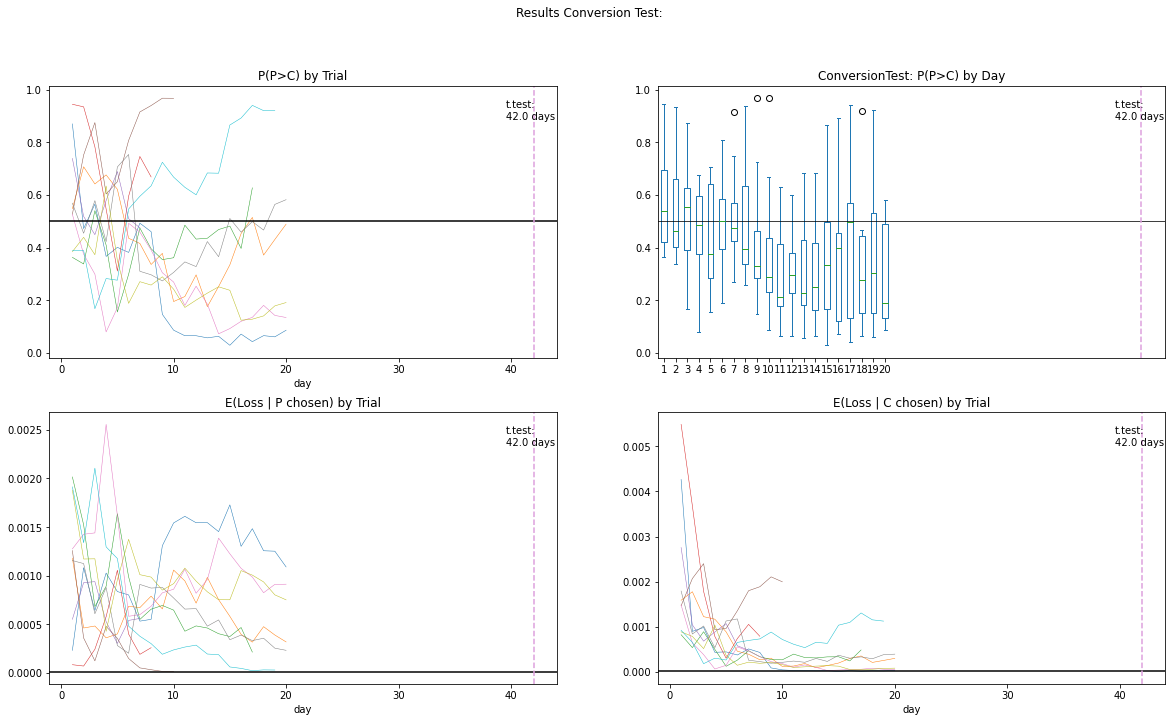

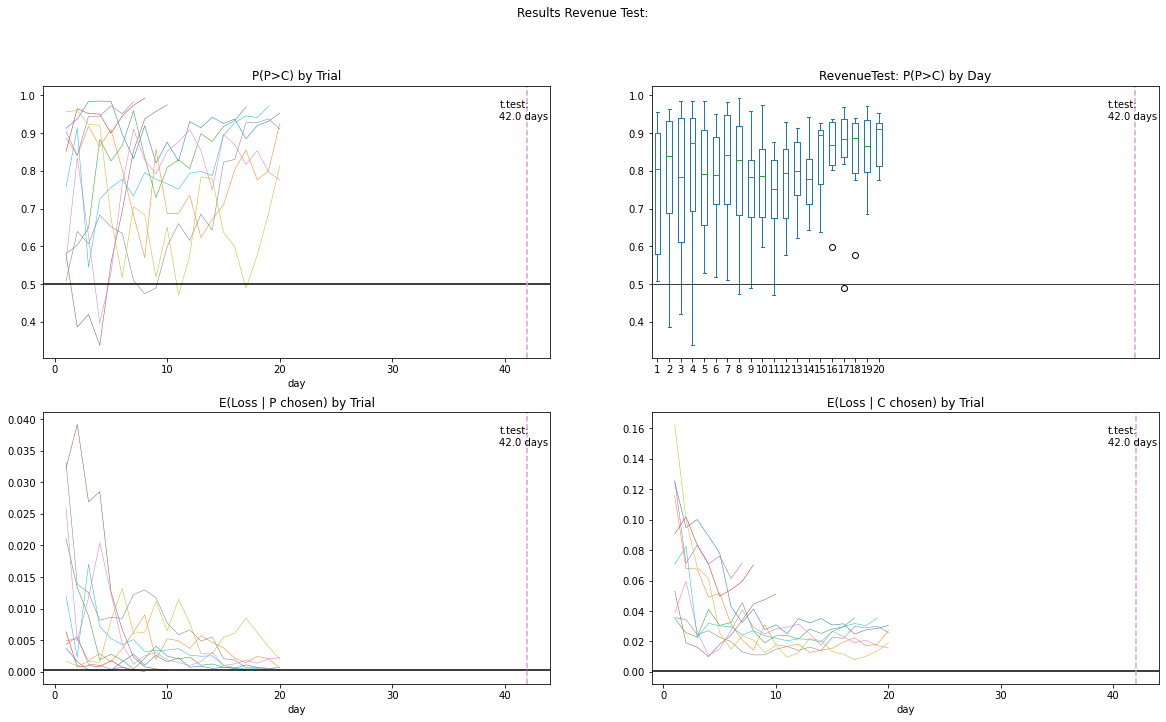

time    5
p       5
Name: revenue_win, dtype: int64


,con_p,con_c,rev_p,rev_c,time
True,NaN,NaN,0.5,NaN,0.5
False,1.0,1.0,0.5,1.0,0.5


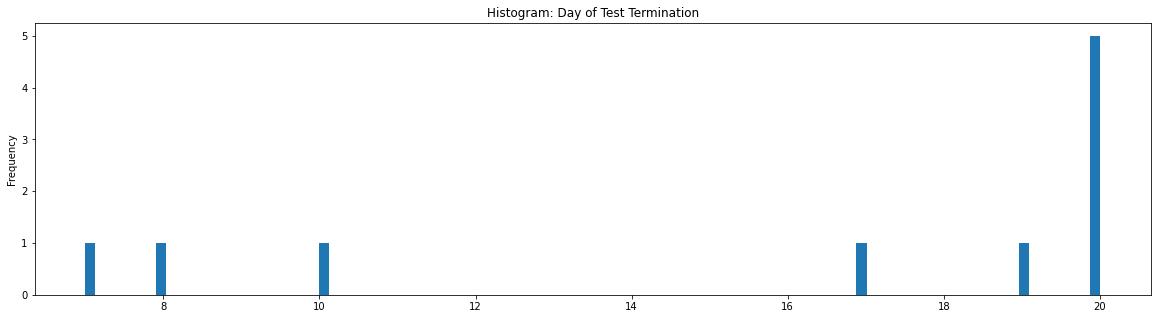

In [9]:
plot_results(c_nU_nU[0], "Conversion", stop_rule_con)
plot_results(c_nU_nU[1], "Revenue", stop_rule_rev)
c_nU_nU[2].day.plot(kind = "hist", bins = n_trials, title = "Histogram: Day of Test Termination", legend = None, figsize=(20, 5))

print(c_nU_nU[2].revenue_win.value_counts())
c_nU_nU[2][['con_p','con_c','rev_p','rev_c','time']].apply(pd.value_counts).sort_index(ascending=False)/10

In [15]:
c_nU_nU_nostop_long = get_all_seq(
    n_trials = n_trials,
    stop_rule_con = 0,
    stop_rule_rev = 0,
    con_multi = 1,
    rev_multi = 1,
    n_days = 200,
    verbose = True,
    verbose_num = 5,
)

Trial 0/100
Trial 5/100
Trial 10/100
Trial 15/100
Trial 20/100
Trial 25/100
Trial 30/100
Trial 35/100
Trial 40/100
Trial 45/100
Trial 50/100
Trial 55/100
Trial 60/100
Trial 65/100
Trial 70/100
Trial 75/100
Trial 80/100
Trial 85/100
Trial 90/100
Trial 95/100


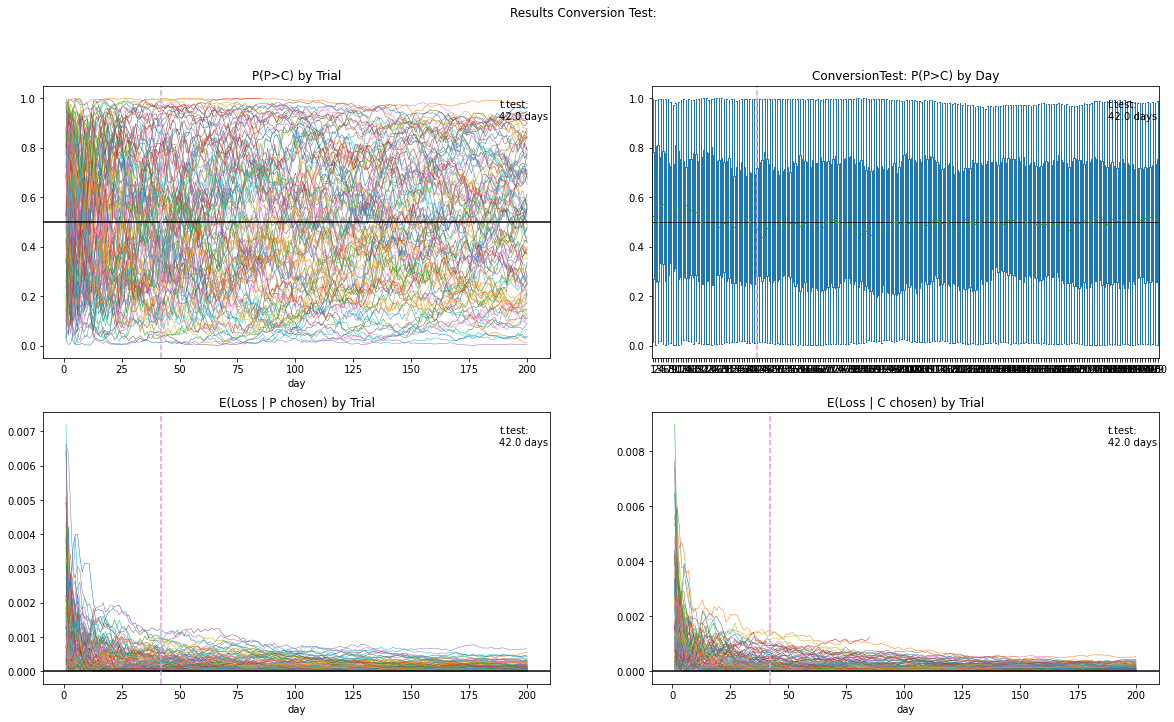

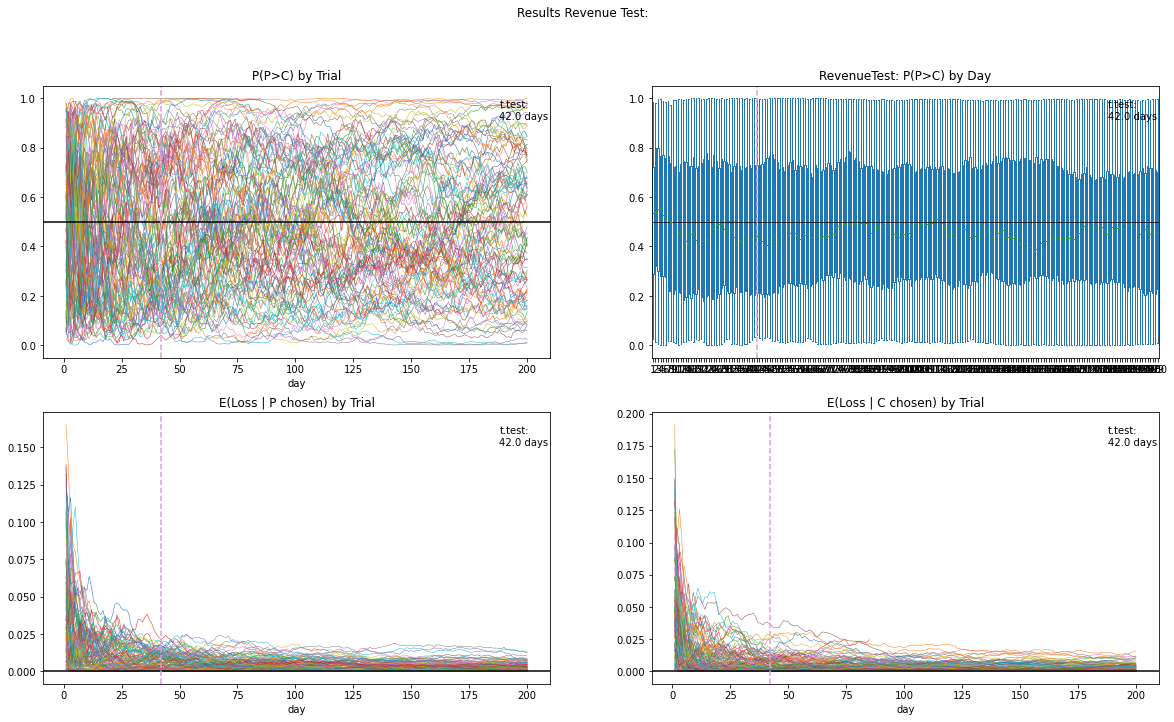

time    99
p        1
Name: revenue_win, dtype: int64


,con_p,con_c,rev_p,rev_c,time
True,0.01,NaN,NaN,NaN,0.99
False,0.99,1.0,1.0,1.0,0.01


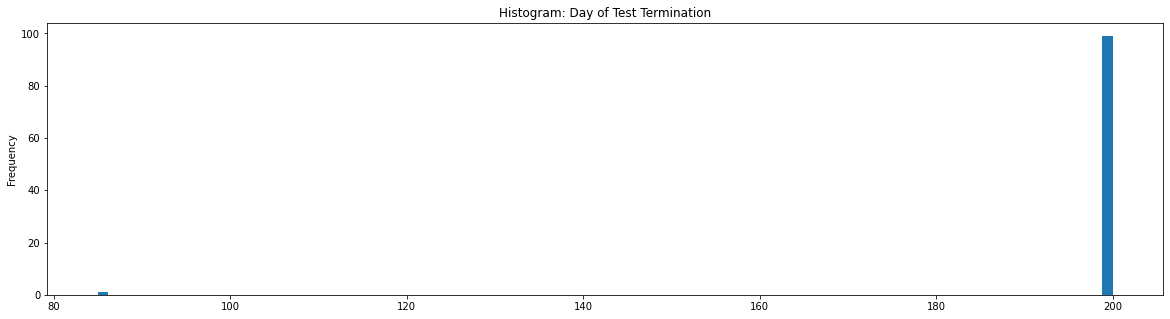

In [16]:
plot_results(c_nU_nU_nostop_long[0], "Conversion", stop_rule_con)
plot_results(c_nU_nU_nostop_long[1], "Revenue", stop_rule_rev)
c_nU_nU_nostop_long[2].day.plot(kind = "hist", bins = n_trials, title = "Histogram: Day of Test Termination", legend = None, figsize=(20, 5))

print(c_nU_nU_nostop_long[2].revenue_win.value_counts())
c_nU_nU_nostop_long[2][['con_p','con_c','rev_p','rev_c','time']].apply(pd.value_counts).sort_index(ascending=False)/n_trials

In [51]:
c_nU_nU = get_all_seq(
    n_trials = n_trials,
    stop_rule_con = stop_rule_con,
    stop_rule_rev = stop_rule_rev,
    con_multi = 1,
    rev_multi = 1,
    n_days = n_days,
)

Trial 0/100
Trial 5/100
Trial 10/100
Trial 15/100
Trial 20/100
Trial 25/100
Trial 30/100
Trial 35/100
Trial 40/100
Trial 45/100
Trial 50/100
Trial 55/100
Trial 60/100
Trial 65/100
Trial 70/100
Trial 75/100
Trial 80/100
Trial 85/100
Trial 90/100
Trial 95/100


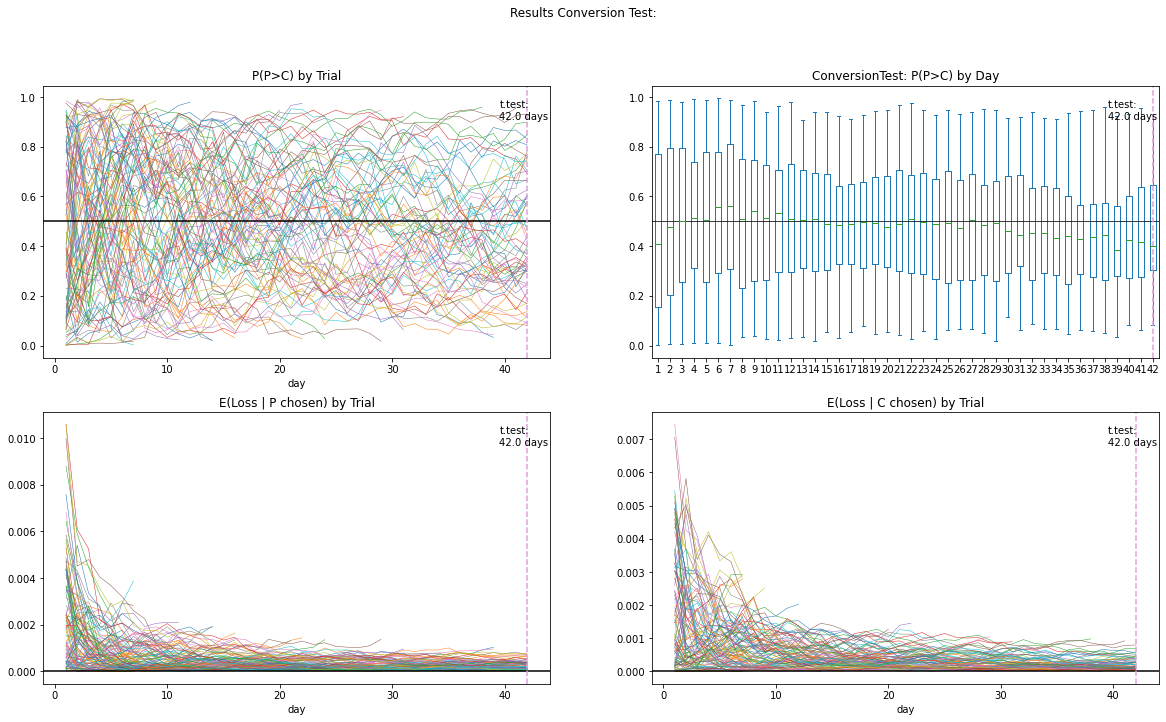

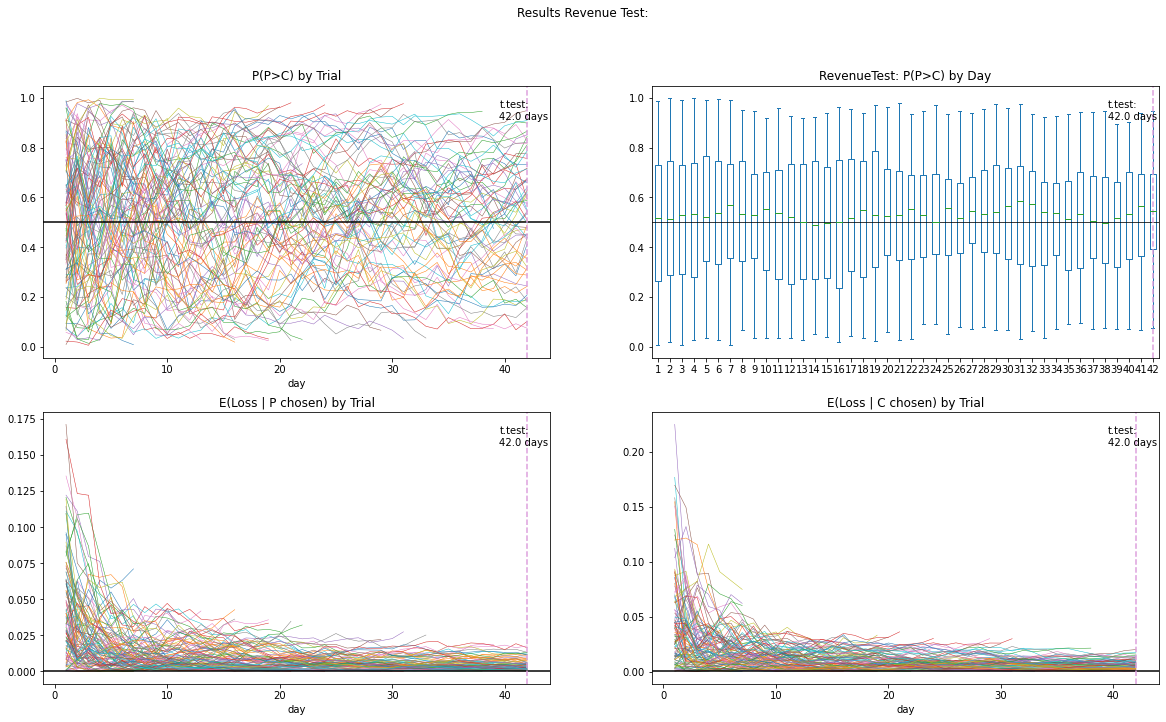

time    63
c       20
p       17
Name: revenue_win, dtype: int64


,con_p,con_c,rev_p,rev_c,time
True,0.09,0.1,0.1,0.1,0.63
False,0.91,0.9,0.9,0.9,0.37


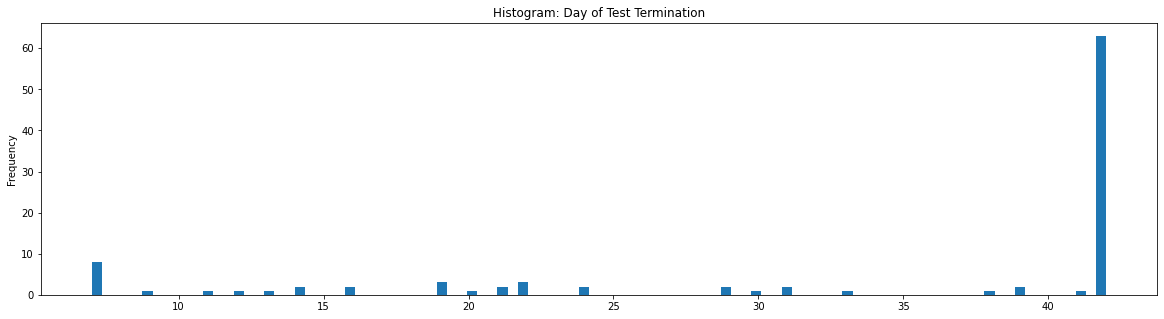

In [52]:
plot_results(c_nU_nU[0], "Conversion", stop_rule_con)
plot_results(c_nU_nU[1], "Revenue", stop_rule_rev)
c_nU_nU[2].day.plot(kind = "hist", bins = n_trials, title = "Histogram: Day of Test Termination", legend = None, figsize=(20, 5))

print(c_nU_nU[2].revenue_win.value_counts())
c_nU_nU[2][['con_p','con_c','rev_p','rev_c','time']].apply(pd.value_counts).sort_index(ascending=False)/n_trials